# Подготовил Шишло Сергей и Polina Seliukh

# Команда JPS_34_dst_20

https://www.kaggle.com/sergejshishlo/notebook5180ce64a4-c69f71

# **Credit Scoring**

Прогнозирование вероятности дефолта заемщика

Представьте, что вы работаете стажером в отделении регионального банка. Вы все также делаете запросы к базам данных и строите отчеты. Вы поймали себя на мысли, что представляли работу дата-саентиста совсем иначе…

И вот сегодня, когда вы уже были на пороге отчаяния, ваш начальник пришел к вам с долгожданной новостью. Будем строить модель!

“Отлично,” – думаете вы, – “наконец-то смогу заняться настоящей работой!”

Вашей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Условия соревнования:
Данное соревнование является бессрочным и доступно для всех потоков.

Срок выполнения соревнования устанавливается индивидуально в каждом потоке.

Тестовая выборка представлена в ЛидерБорде целиком.

Поэтому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку).

Разрешено использовать любые ML алгоритмы и библиотеки (кроме DL).

Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime
import plotly.express as px
from pandas import Series


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor 


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
%matplotlib inline

# 0. Подготовим функции и классы для дальнейшей работы

In [82]:
 # класс для построения визуализация для числового признака и нахождения выбросов.

class AnalyzNumCol():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False):
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))
        
        fig.suptitle('Histogram, QQ-plot and boxplot for {0} '.format(column))
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'red')
        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax2) 
        
        
        
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def emission_limits(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, log = False): 
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.emission_limits(log)
        return len(data[data < minb])+ len(data[data > maxb])

    
# класс логарифмирования признака
    
class LogDf(): 
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 

In [83]:
# метрика для оценки модели

class MatrixModel(): 
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'spring', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок для default')
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)

        plt.show()

# **1. Импортируем данные**

In [84]:
data_directory = '/kaggle/input/sf-dst-scoring/'
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
#sample_submission = pd.read_csv('sample_submission.csv')

In [85]:
print('данные для обучения')
data_train.info()

данные для обучения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
client_id           73799 non-null int64
app_date            73799 non-null object
education           73492 non-null object
sex                 73799 non-null object
age                 73799 non-null int64
car                 73799 non-null object
car_type            73799 non-null object
decline_app_cnt     73799 non-null int64
good_work           73799 non-null int64
score_bki           73799 non-null float64
bki_request_cnt     73799 non-null int64
region_rating       73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null int64
sna                 73799 non-null int64
first_time          73799 non-null int64
foreign_passport    73799 non-null object
default             73799 non-null int64
dtypes: float64(1), int64(12), object(6)
memory usage: 10.7+ MB


**Вывод**

т.к. пропуски представлены в столбце 'education' и составляют около 0.4% то данные с пропущенными значениями удалим

In [86]:
print('данные для проверки')
data_test.info()

данные для проверки
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
client_id           36349 non-null int64
app_date            36349 non-null object
education           36178 non-null object
sex                 36349 non-null object
age                 36349 non-null int64
car                 36349 non-null object
car_type            36349 non-null object
decline_app_cnt     36349 non-null int64
good_work           36349 non-null int64
score_bki           36349 non-null float64
bki_request_cnt     36349 non-null int64
region_rating       36349 non-null int64
home_address        36349 non-null int64
work_address        36349 non-null int64
income              36349 non-null int64
sna                 36349 non-null int64
first_time          36349 non-null int64
foreign_passport    36349 non-null object
dtypes: float64(1), int64(11), object(6)
memory usage: 5.0+ MB


**Вывод**

т.к. пропуски представлены в столбце 'education' и составляют около 0.4% то данные с пропущенными значениями удалим

In [87]:
# зафиксируем константы
!pip freeze > requirements.txt
RANDOM_SEED = 42
CURRENT_DATE = datetime.now()

In [88]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
data_train['Train'] = 1 # помечаем где у нас трейн
data_test['Train'] = 0 # помечаем где у нас тест

data = data_train.append(data_test, sort=False).reset_index(drop=True) # объединяем

In [89]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

In [90]:
data.shape

(110148, 20)

In [91]:
data['education'] = data['education'].fillna(data.education.mode()[0])

**Вывод**

'default' имеет 36178 пропусков. Эти пропуски в будущем необходимо заполнить. 

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту
В тренировочном наборе 73492 записей, в тестовой - 36178. Всего 19 переменных (18 признаков + целевая).

In [92]:
# исправим дату
data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')


In [93]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


# 2. Предварительный анализ данных

In [94]:
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [95]:
data.describe(include = 'object')

,education,sex,car,car_type,foreign_passport
count,110148,110148,110148,110148,110148
unique,5,2,2,2,2
top,SCH,F,N,N,N
freq,58476,61836,74290,89140,93721


In [96]:
# переведем данные в цифровой формат

label_encoder = LabelEncoder()

for column in ['education', 'sex', 'car', 'car_type', 'foreign_passport']:
    data[column] = label_encoder.fit_transform(data[column])
    


In [97]:
data.describe()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,2.477739,0.438610,39.249410,0.325544,0.190725,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.149136,0.126994,0.669999
std,31797.133063,1.079096,0.496219,11.518063,0.468580,0.392875,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.356224,0.332968,0.470215
min,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,27537.750000,1.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,55074.500000,3.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,0.000000,1.000000
75%,82611.250000,3.000000,1.000000,48.000000,1.000000,0.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,0.000000,1.000000
max,110148.000000,4.000000,1.000000,72.000000,1.000000,1.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000,1.000000


**Вывод**

*С 90% вероятностью можно сказать что дефолт наступит в следующем случае:*
   1. Дефолту подвержены люди всех видов образования, пола, наличия автомобиля и автомобиля иностранного производства, категоризатор домашнего адреса, категоризатор рабочего адреса, наличие загранпаспорта, давность наличия информации о заемщике,region_rating.
   2. На невозврат долга существенное влияние оказывают следующие факторы:
* количество отказанных прошлых заявок. При этом если количество откланенных заявок выше 15 то наблюдается явный эффект организации возврата; 
* скоринговый балл по данным из БКИ. Находится ниже 0.2;
* если количество запросов в БКИ не большое, то вероятность дефолта высокая;
* люди с низким доходом, до 0.4-0.5 М.

С 90% вероятностью можно сказать, что наступление дефолта равно 0:
   1. расширился возраст т.е. пенсионеры за 70 лучше платят, увеличелось число отказов и количество запросов БКИ, однозначно выросли доходы.

**Проверим как на возврат влияет день месяца и месяц**

In [100]:
data['day'] = data['app_date'].dt.day
data['month'] = data['app_date'].dt.month


**Вывод**

Дни месяца и номер месяца не играет существенной роли при определении дефолта. Однако стоит отметить, что время играет важную роль в различных скоринговых моделях, то создадим новый новый признак дельту от конца 2020 года.

In [103]:
NY_2020 = pd.to_datetime('31/12/2020')

In [104]:
data['delta_time'] = (NY_2020 - data['app_date']).dt.days
data[data.month == 1]['delta_time'].head()

3     2534
9     2547
12    2549
15    2535
16    2527
Name: delta_time, dtype: int64

**Вывод**

Из данных удалим признаки app_date, month, day

In [105]:
data.drop(['day', 'app_date', 'month'],  axis = 1, inplace = True)

# 3. Обработка признаков в данных

In [106]:
cols = data.columns
for col in cols:
    if data[col].dtype != 'O' and len(data[col].unique())<=20:
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))
    else:
        print('Числовой признак {}'.format(col))

Числовой признак client_id
Уникальные значения в поле education : [3 1 4 2 0]
Уникальные значения в поле sex : [1 0]
Числовой признак age
Уникальные значения в поле car : [1 0]
Уникальные значения в поле car_type : [1 0]
Числовой признак decline_app_cnt
Уникальные значения в поле good_work : [0 1]
Числовой признак score_bki
Числовой признак bki_request_cnt
Уникальные значения в поле region_rating : [50 80 60 40 70 20 30]
Уникальные значения в поле home_address : [1 2 3]
Уникальные значения в поле work_address : [2 3 1]
Числовой признак income
Уникальные значения в поле sna : [4 1 2 3]
Уникальные значения в поле first_time : [1 4 3 2]
Уникальные значения в поле foreign_passport : [0 1]
Уникальные значения в поле default : [ 0.  1. nan]
Уникальные значения в поле Train : [1 0]
Числовой признак delta_time


Проанализируем числовые данные

In [107]:
# age

age = AnalyzNumCol(data[data.Train == 1], 'age')

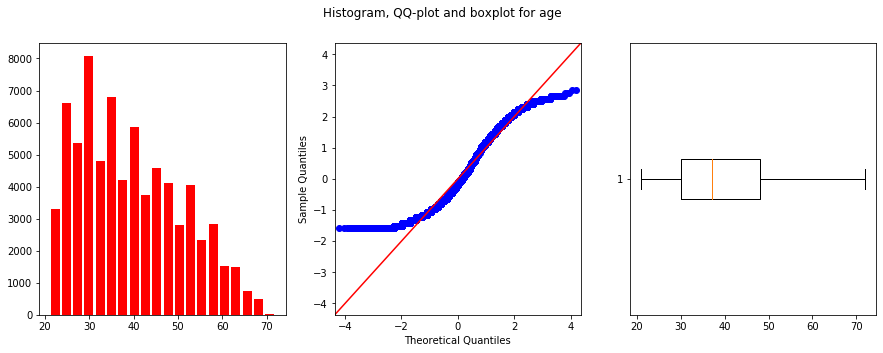

In [108]:
age.show_plots()

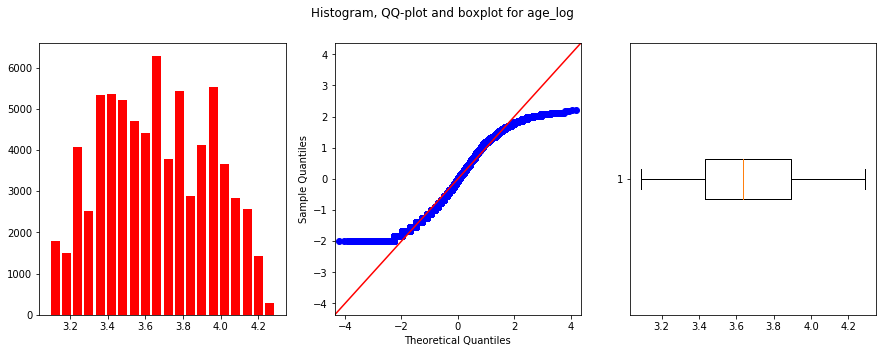

In [109]:
age.show_plots(log = True)

**Вывод**

Признак распределен нормально. И выбросы отсутсвуют. Стоит отметить, что после логорифмирования признак к стал стремиться еще больше к нормальности. 

Таким образом логорифмируем признак age

In [110]:
data['age'] = np.log(data['age'] + 1)

In [111]:
# decline_app_cnt

decline_app_cnt = AnalyzNumCol(data[data.Train == 1], 'decline_app_cnt')

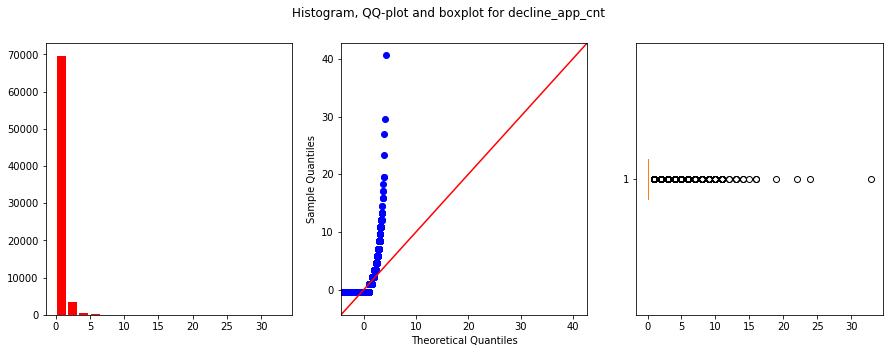

In [112]:
decline_app_cnt.show_plots()

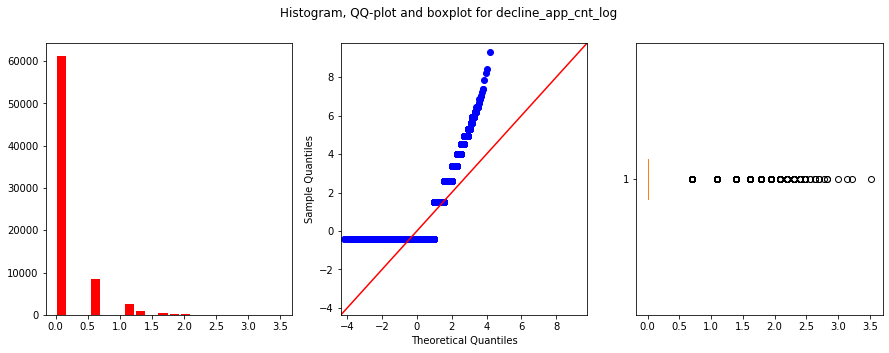

In [113]:
decline_app_cnt.show_plots(log = True)

**Вывод**

В признаке decline_app_cnt наблюдается сильное смещение. Применение логорифмирования улучшело данный признак 

Просмотрим выбросы

In [114]:
print('Суммарное количество выбросов для decline_app_cnt: ', decline_app_cnt.amount_emissions())
print('Суммарное количество выбросов для log(decline_app_cnt): ', decline_app_cnt.amount_emissions(log = True))

Суммарное количество выбросов для decline_app_cnt:  12585
Суммарное количество выбросов для log(decline_app_cnt):  12585


In [115]:
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)

**Вывод**

Выбросов большое количество, на данном этапе оставим их в работе



Так как в основе данного признака лежит отказ в кредитовании, то можно создать либо бинарный признак был отказ или не был отказ или категориальный признак: не было отказа (0), 1 отказ (1) и 2 и более отказов (2). Исходя из предыдущего анализа добавим бинарный признак

In [116]:
data['decline_yes'] = data['decline_app_cnt'].apply(lambda x: 0 if x < 1 else 1)

In [117]:
# score_bki

score_bki = AnalyzNumCol(data[data.Train == 1], 'score_bki')

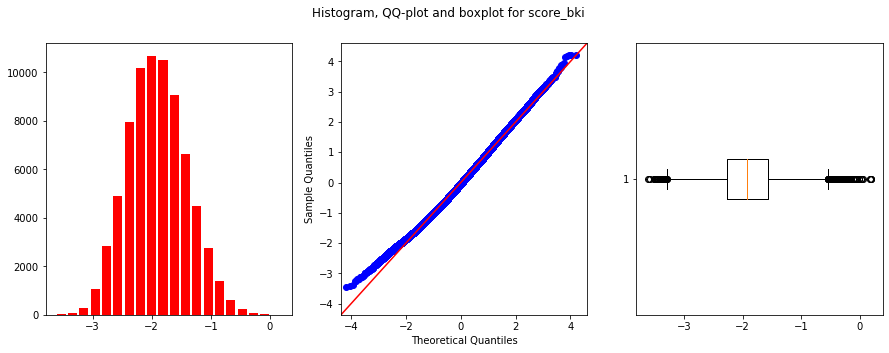

In [118]:
score_bki.show_plots()

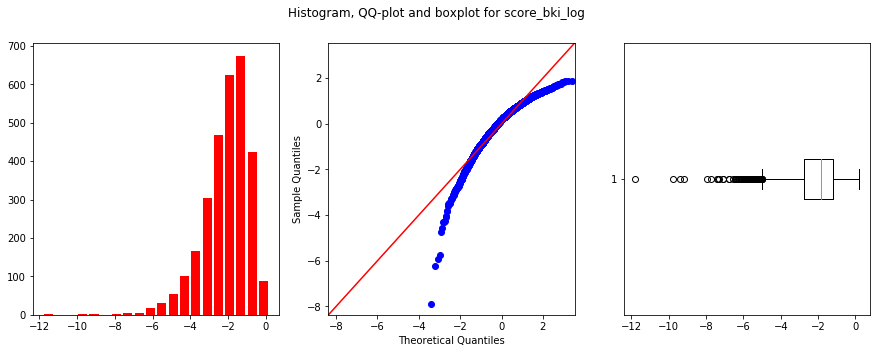

In [119]:
score_bki.show_plots(log=True)

**Вывод**

Признак нормально распределен но у него большое количество выбрасов. ПРосмотрим количество выбросов

In [120]:
print('Суммарное количество выбросов для score_bki: ', score_bki.amount_emissions())
print('Суммарное количество выбросов для log(score_bki): ', score_bki.amount_emissions(log = True))

Суммарное количество выбросов для score_bki:  351
Суммарное количество выбросов для log(score_bki):  85


**Вывод**
Признак логорифмировать не будем, удалать выбросы не будем т.к. их небольшое количество

In [121]:
# bki_request_cnt

bki_request_cnt = AnalyzNumCol(data[data.Train == 1], 'bki_request_cnt')

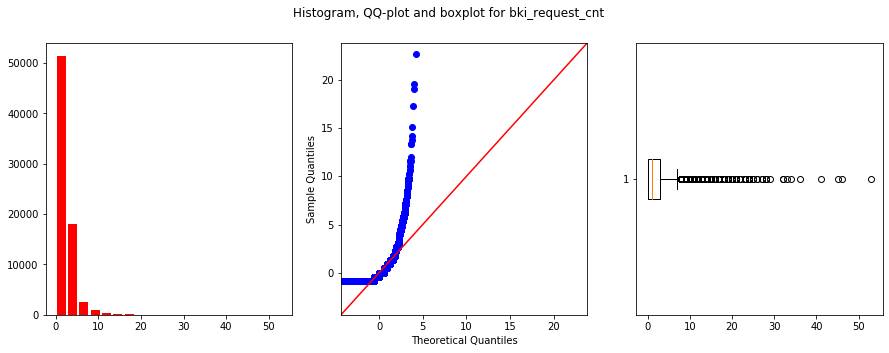

In [122]:
bki_request_cnt.show_plots()

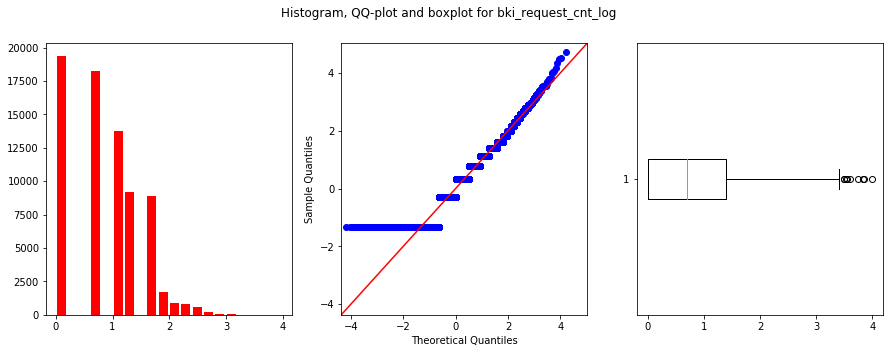

In [123]:
bki_request_cnt.show_plots(log = True)

**Вывод **

При логорифмировании критерий становиться ближе к нормальному распределению. У нас есть выбросы, которые необходимо дополнительно обработать

In [124]:
print('Суммарное количество выбросов для bki_request_cnt: ', bki_request_cnt.amount_emissions())
print('Суммарное количество выбросов для log(bki_request_cnt): ', bki_request_cnt.amount_emissions(log = True))

Суммарное количество выбросов для bki_request_cnt:  1755
Суммарное количество выбросов для log(bki_request_cnt):  9


In [125]:
data['bki_request_cnt'] = np.log(data['bki_request_cnt'] + 1)

После логорифмирования количество выбросов существенно уменьшилось.

Также благодаря ранее сделанному анализу можно добавть бинарный признак до 10 запросов и более (в итоге признак не подешел)

In [126]:
#data['bki_request_cnt_10'] = data['bki_request_cnt'].apply(lambda x: 0 if x <= 10 else 1)

In [127]:
# income

income = AnalyzNumCol(data[data.Train == 1], 'income')

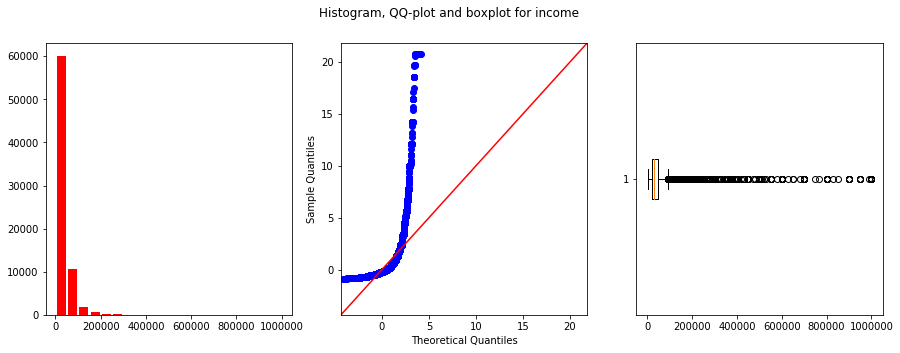

In [128]:
income.show_plots()

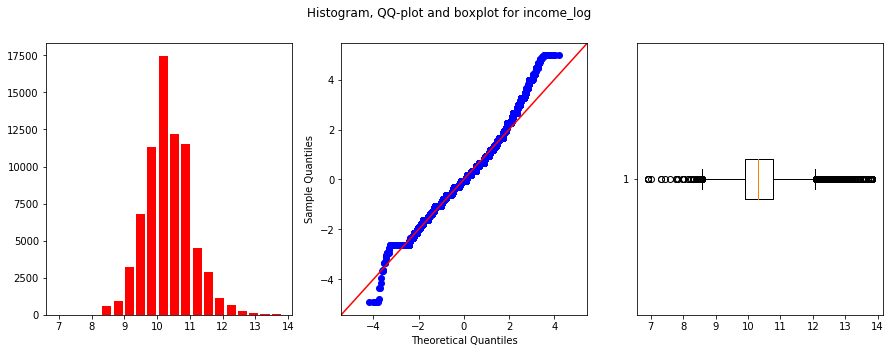

In [129]:
income.show_plots(log = True)

Вывод логорифмирование существенно улучшело распределение признака, прологорифмируем признак и проверем количество пропусков

In [130]:
print('Суммарное количество выбросов для income: ', income.amount_emissions())
print('Суммарное количество выбросов для log(income): ', income.amount_emissions(log = True))

Суммарное количество выбросов для income:  4695
Суммарное количество выбросов для log(income):  1767


Выбросы удолять пока не будем.

In [131]:
data['income'] = np.log(data['income'] + 1)

In [132]:
# delta_time

delta_time = AnalyzNumCol(data[data.Train == 1], 'delta_time')

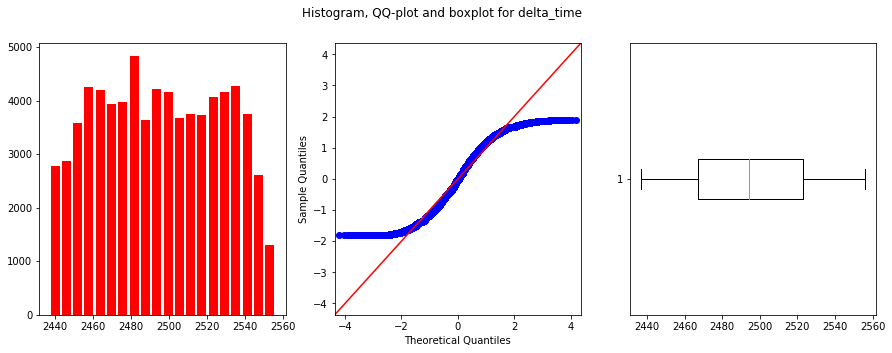

In [133]:
delta_time.show_plots()

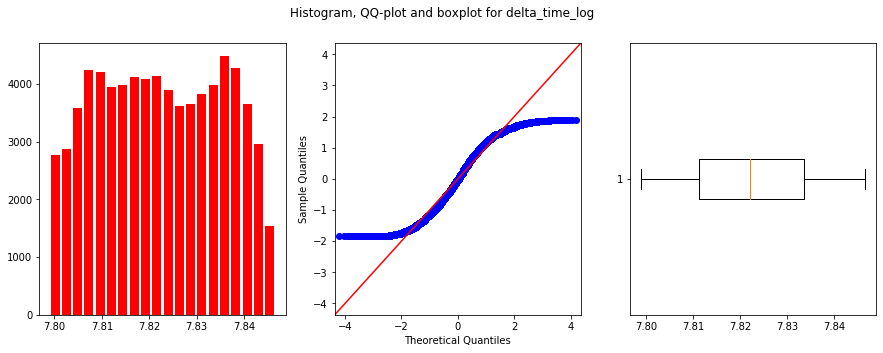

In [134]:
delta_time.show_plots(log = True)

Логорифмирование никак не повлияли на признак, выбросов у признака нет

In [135]:
# q_app

#q_app = AnalyzNumCol(data[data.Train == 1], 'q_app')

In [136]:
#q_app.show_plots()

In [137]:
#q_app.show_plots(log = True)

критерий не стоит логорифмировать

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
client_id           110148 non-null int64
education           110148 non-null int32
sex                 110148 non-null int32
age                 110148 non-null float64
car                 110148 non-null int32
car_type            110148 non-null int32
decline_app_cnt     110148 non-null float64
good_work           110148 non-null int64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null float64
region_rating       110148 non-null int64
home_address        110148 non-null int64
work_address        110148 non-null int64
income              110148 non-null float64
sna                 110148 non-null int64
first_time          110148 non-null int64
foreign_passport    110148 non-null int32
default             73799 non-null float64
Train               110148 non-null int64
delta_time          110148 non-null int64
decline_yes         110148 non-null in

In [139]:
for i in data.columns:
    print(i)
    print(data[i].value_counts())

client_id
2047     1
97541    1
93447    1
70920    1
72969    1
        ..
47810    1
45763    1
35524    1
33477    1
2049     1
Name: client_id, Length: 110148, dtype: int64
education
3    58476
1    34768
4    14748
2     1865
0      291
Name: education, dtype: int64
sex
0    61836
1    48312
Name: sex, dtype: int64
age
3.465736    4084
3.433987    4035
3.367296    4035
3.332205    3964
3.401197    3940
3.295837    3780
3.496508    3773
3.555348    3548
3.526361    3499
3.583519    3386
3.258097    3292
3.610918    3228
3.637586    3185
3.688879    3095
3.663562    3070
3.713572    2950
3.761200    2857
3.737670    2804
3.218876    2780
3.784190    2672
3.806662    2536
3.178054    2295
3.828641    2235
3.931826    2104
3.850148    2102
3.891820    2084
3.871201    2074
3.970292    2065
3.951244    2015
3.988984    1980
3.912023    1964
4.007333    1911
4.025352    1837
4.043051    1641
4.060443    1578
3.135494    1415
4.077537    1373
4.094345    1340
3.091042    1262
4.110874   

In [140]:
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'region_rating', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'delta_time']

Выделим поля с числовыми, бинарными и категориальными данными

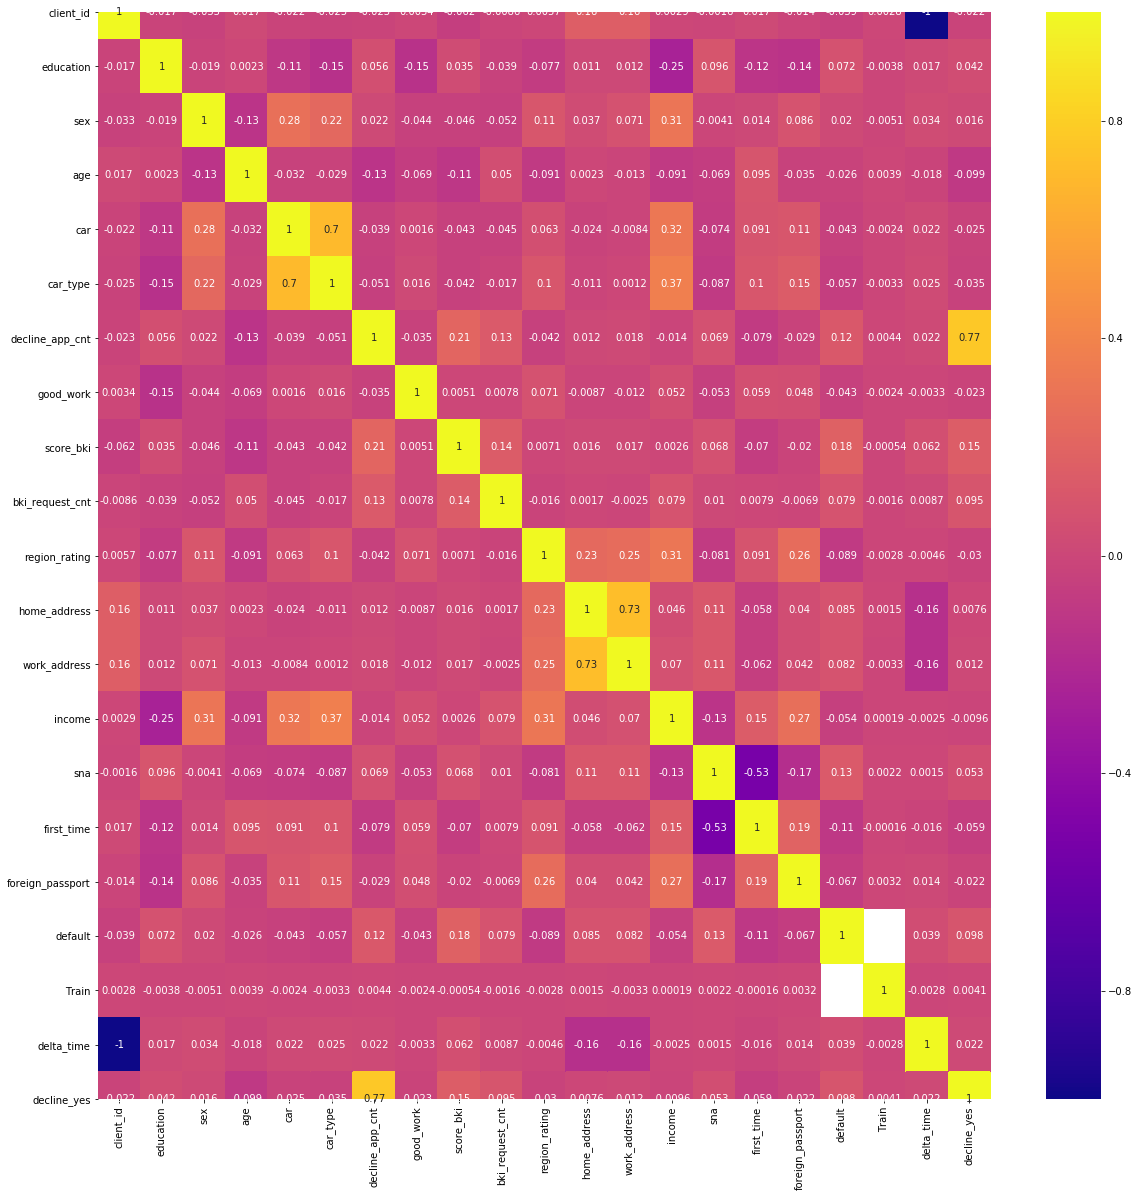

In [141]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'plasma')

**Вывод**

таким образом созданный признак имеет высокий коэффициент корреляции, признак bki_request_cnt_10 удаляем

Проверим значимость непрерывных переменных (на основе однофакторного дисперсионного анализа (ANOVA)) Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

В качестве меры значимости мы будем использовать значение f -статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.

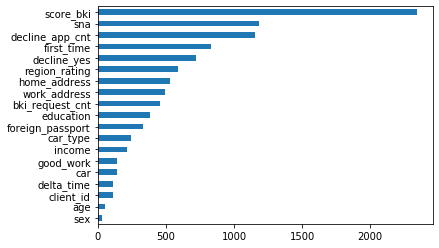

In [142]:
imp_num = Series(f_classif(data[data.Train == 1].drop(['Train', 'default'], axis = 1), data[data.Train == 1]['default'])[0], index = data.drop(['Train', 'default'], axis = 1).columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самым значимым фактором является score_bki мене значимыми факторами пол и возраст

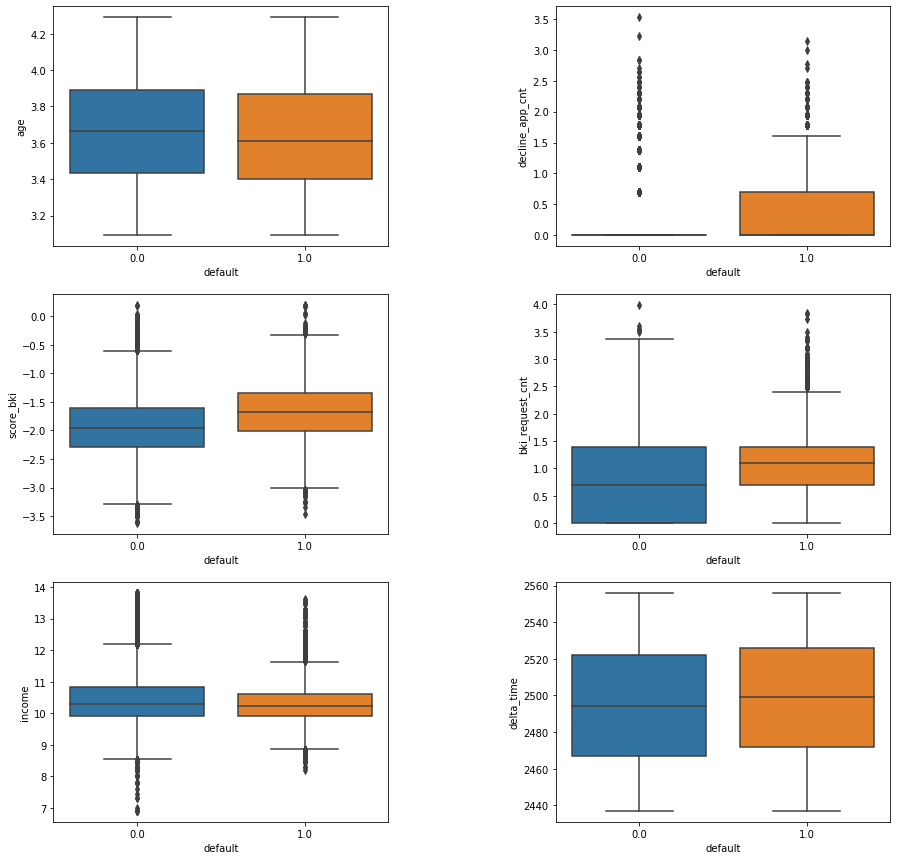

In [143]:
# Построим boxplot’ы для численных переменных
fig, axes = plt.subplots(3, 2, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()

for i in range(len(num_cols)):
    sns.boxplot(x="default", y=num_cols[i], data=data[data.Train == 1], orient = 'v', ax=axes[i])


**Вывод**

1. Средний возраст дефолтных клиентов ниже, чем у не дефолтных.
2. Количество отказанных прошлых заявок выше для для дефолтных клиентов.
3. Скоринговый балл по данным из БКИ выше для дефолтных.
4. Количество запросов в БКИ для дефолтных значительно больше.
5. Доход для дефолтных меньше. 
6. Дефолтные клиенты в среднем дальше от сегодняшнего дня.

In [144]:
data[data.Train == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 21 columns):
client_id           73799 non-null int64
education           73799 non-null int32
sex                 73799 non-null int32
age                 73799 non-null float64
car                 73799 non-null int32
car_type            73799 non-null int32
decline_app_cnt     73799 non-null float64
good_work           73799 non-null int64
score_bki           73799 non-null float64
bki_request_cnt     73799 non-null float64
region_rating       73799 non-null int64
home_address        73799 non-null int64
work_address        73799 non-null int64
income              73799 non-null float64
sna                 73799 non-null int64
first_time          73799 non-null int64
foreign_passport    73799 non-null int32
default             73799 non-null float64
Train               73799 non-null int64
delta_time          73799 non-null int64
decline_yes         73799 non-null int64
dtypes: float64(6)

# Создадим новые метрики на основе get_dummies из категориальных критериев

In [145]:
# закодируем категориальные признаки при помощи get_dummy
data_cat = pd.get_dummies(data.loc[:, cat_cols], columns = cat_cols)
data_cat.head()

,education_0,education_1,education_2,education_3,education_4,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,...,region_rating_70,region_rating_80,sna_1,sna_2,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4
0,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0,1,0,1,0,0,0,1,...,0,1,1,0,0,0,0,0,0,1
3,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Удалим признак decline_yes

In [146]:
data = data.drop('decline_yes', axis = 1)

# Стандартизируем числовые данные

In [147]:
# стандартизиуем числовые признаки

data_num = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = num_cols)

# Объединим все признаки и разделим DF на обучающую и тестовую  

In [148]:
# объединим все в один DF
data_end = pd.concat([data_num, data_cat, data[bin_cols], data['Train'], data['default']], axis = 1)

In [149]:
data_end.Train.value_counts()

1    73799
0    36349
Name: Train, dtype: int64

In [150]:
data_standart_train = data_end[data_end.Train == 1]
data_standart_test = data_end[data_end.Train == 0]


In [151]:
data_standart_train = data_standart_train.drop('Train', axis = 1)
data_standart_test = data_standart_test.drop('Train', axis = 1)

In [152]:
data_standart_test.shape

(36349, 38)

# 4.Работа по обучению модели по прогнозированию default и улучшению параметров модели. В качестве ML будем использовать модель логистической регрессии

In [153]:
data_end.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 39 columns):
age                 110148 non-null float64
decline_app_cnt     110148 non-null float64
score_bki           110148 non-null float64
bki_request_cnt     110148 non-null float64
income              110148 non-null float64
delta_time          110148 non-null float64
education_0         110148 non-null uint8
education_1         110148 non-null uint8
education_2         110148 non-null uint8
education_3         110148 non-null uint8
education_4         110148 non-null uint8
home_address_1      110148 non-null uint8
home_address_2      110148 non-null uint8
home_address_3      110148 non-null uint8
work_address_1      110148 non-null uint8
work_address_2      110148 non-null uint8
work_address_3      110148 non-null uint8
region_rating_20    110148 non-null uint8
region_rating_30    110148 non-null uint8
region_rating_40    110148 non-null uint8
region_rating_50    110148 non-null u

In [154]:
X = data_standart_train.drop('default', axis = 1)
y = data_standart_train['default']

In [155]:
# Выделим из тренировочного датасета 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Проверка
print(X.shape, X_train.shape, X_test.shape)

(73799, 37) (59039, 37) (14760, 37)


In [156]:
#Обучим модель
warnings.simplefilter('ignore')

model = LogisticRegression(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

Оценим метрики на полученной модели

In [157]:
model_1 = MatrixModel(model, X_test, y_test)

In [158]:
model_1.get_metrics()

accuracy     0.874729
precision    0.394231
recall       0.022441
F1           0.042465
ROC_AUC      0.744768
dtype: float64

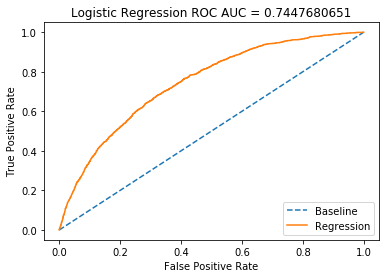

In [159]:
model_1.roc_curve_plot()

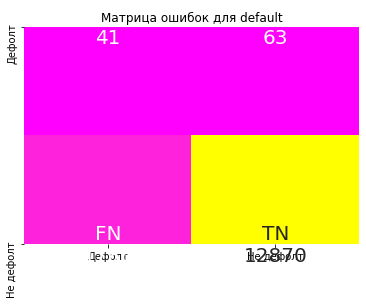

In [160]:
model_1.confusion_matrix_plot()

**Вывод**

Наблюдается явная несбалансированность показателей качества модели при этои стоит отметить что ROC_AUC и accurcy имеют достаточно хорошее значение, при этом precision, recall и F1 имеют низкое значение, говорит о появлении ошибки второго рода (ложно отритйательный, деволт классифицирован как не дефолт). Вследствии с вышесказанным банк может понести дополнительные убытки за счет выдачи кредитов неправильным заемщикам. Для разрешения данной проблемы необходимо сбалансировать модель, применить регуляризацию и попытаться подобрать гиперпараметры модели.

# Сбалансированность данных 

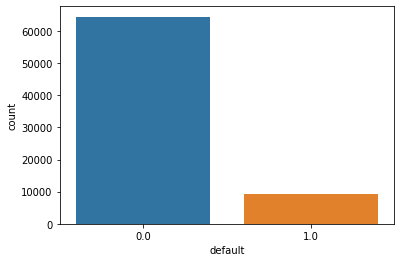

In [161]:
sns.countplot(x='default', data=data_standart_train)

In [162]:
print('класс 0: ', len(data_standart_train[data_standart_train.default == 0]))
print('класс 1: ', len(data_standart_train[data_standart_train.default == 1]))
print('веса классов: отношение дефолтных клиентов к недефолтным = {0}'.format(len(data_standart_train[data_standart_train.default == 0]) / len(data_standart_train[data_standart_train.default == 1])))

класс 0:  64427
класс 1:  9372
веса классов: отношение дефолтных клиентов к недефолтным = 6.874413145539906


Как видно недефолтных клиентов в 6.87 раза больше, чем дефолтных.
Для сглаживания модели применим параметр модели class_weight = 'balanced'

In [163]:
model = LogisticRegression(class_weight='balanced', random_state = RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [164]:
model_2 = MatrixModel(model, X_test, y_test)

In [165]:
model_2.get_metrics()

accuracy     0.671070
precision    0.226715
recall       0.687466
F1           0.340980
ROC_AUC      0.744221
dtype: float64

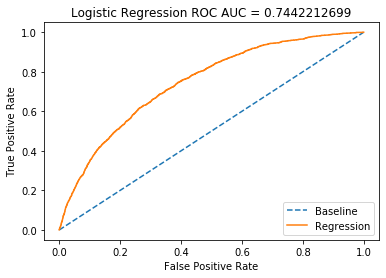

In [166]:
model_2.roc_curve_plot()

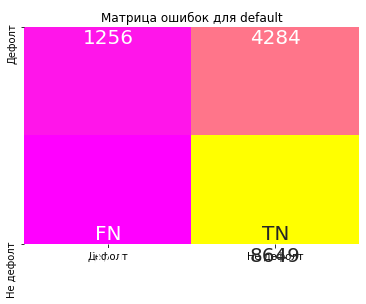

In [167]:
model_2.confusion_matrix_plot()

В целом применение балансировки позволило, сократить ошибку второго рода, но увеличило ошибку первого рода (не дефолтных классифицировали как дефолтных). Это приводит к увеличению экономических издержек и недополучению банком прибыли. 

# Подберем параметры модели

In [168]:
# параметры подбирались согласно документации
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

C = np.logspace(-1, 4, 10)
iter_ = 1000
epsilon_stop = 1e-4
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки

In [169]:
model = LogisticRegression(class_weight = 'balanced', random_state = RANDOM_SEED)

In [170]:
# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

In [171]:
best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')

Лучшие значения параметров:
  C = 0.35938136638046275,
  class_weight = balanced,
  dual = False,
  fit_intercept = True,
  intercept_scaling = 1,
  l1_ratio = None,
  max_iter = 1000,
  multi_class = auto,
  n_jobs = None,
  penalty = l1,
  random_state = 42,
  solver = liblinear,
  tol = 0.0001,
  verbose = 0,
  warm_start = False,


In [172]:
model_3 = MatrixModel(model_best_params, X_test, y_test)

In [173]:
model_3.get_metrics()

accuracy     0.671070
precision    0.226813
recall       0.688013
F1           0.341159
ROC_AUC      0.744288
dtype: float64

# Так как осуществлялся подбор большого числа гиперпараметров, то проверем модель на переобучение 

In [174]:
from sklearn.model_selection import cross_validate

In [175]:
clf = LogisticRegression(
    C = 0.35938136638046275,
    class_weight = 'balanced',
    dual = False,
    fit_intercept = True,
    intercept_scaling = 1,
    l1_ratio = None,
    max_iter = 1000,
    multi_class = 'auto',
    n_jobs = None,
    penalty = 'l1',
    random_state = 42,
    solver = 'liblinear',
    tol = 0.0001,
    verbose = 0,
    warm_start = False
)
    
cv_metrics = cross_validate(clf, X, y, cv=10, scoring='f1_micro', return_train_score=True)

[train] F1-score = 0.67 +/- 0.00
[valid] F1-score = 0.67 +/- 0.01


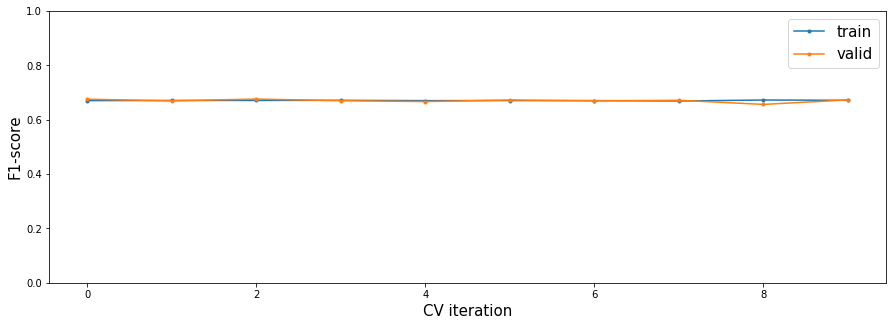

In [176]:
avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
plt.figure(figsize=(15, 5))

plt.plot(cv_metrics['train_score'], label='train', marker='.')
plt.plot(cv_metrics['test_score'], label='valid', marker='.')

plt.ylim([0., 1.]);
plt.xlabel('CV iteration', fontsize=15)
plt.ylabel('F1-score', fontsize=15)
plt.legend(fontsize=15)

Как видно модель фактически не переобучилась

# Вывод

1. Благодоря подблору параметров удалось улучшить recall, f1 и precision
2. Ошибка второго рода сократилась , при этом увеличилась ошибка 1 рода, которая не несет явных экономических затрат, но увеличивает не явные.
3. На метрику ROC_AUC подбор параметров повлиял не сильно.

# Submission

In [177]:
clf = LogisticRegression(
    C = 0.35938136638046275,
    class_weight = 'balanced',
    dual = False,
    fit_intercept = True,
    intercept_scaling = 1,
    l1_ratio = None,
    max_iter = 1000,
    multi_class = 'auto',
    n_jobs = None,
    penalty = 'l1',
    random_state = 42,
    solver = 'liblinear',
    tol = 0.0001,
    verbose = 0,
    warm_start = False
)

In [178]:
clf.fit(X, y)

LogisticRegression(C=0.35938136638046275, class_weight='balanced',
                   max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

In [179]:
X_test = data_standart_test.drop(['default'], axis=1)
y_pred_prob = clf.predict_proba(X_test)[:,1]

submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)